<a href="https://colab.research.google.com/github/pkmariya/Scaler01/blob/master/ScalerCluster_CaseStudy_Mariya_DSML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Objective**
As a data scientist at analytics vertical of Scaler, you are tasked to cluster the learners on the basis of their job profile, company, and other features to derive the best companies and job positions to work for.

In [2]:
# Import required libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage

import warnings
warnings.filterwarnings('ignore')

In [3]:
data_df = pd.read_csv('https://d2beiqkhq929f0.cloudfront.net/public_assets/assets/000/002/856/original/scaler_clustering.csv')

In [4]:
print("Given dataset contains {0} Rows and {1} Columns".format(data_df.shape[0], data_df.shape[1]))

Given dataset contains 205843 Rows and 7 Columns


In [5]:
data_df.describe()

,Unnamed: 0,orgyear,ctc,ctc_updated_year
count,205843.000000,205757.000000,2.058430e+05,205843.000000
mean,103273.941786,2014.882750,2.271685e+06,2019.628231
std,59741.306484,63.571115,1.180091e+07,1.325104
min,0.000000,0.000000,2.000000e+00,2015.000000
25%,51518.500000,2013.000000,5.300000e+05,2019.000000
50%,103151.000000,2016.000000,9.500000e+05,2020.000000
75%,154992.500000,2018.000000,1.700000e+06,2021.000000
max,206922.000000,20165.000000,1.000150e+09,2021.000000


In [6]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205843 entries, 0 to 205842
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        205843 non-null  int64  
 1   company_hash      205799 non-null  object 
 2   email_hash        205843 non-null  object 
 3   orgyear           205757 non-null  float64
 4   ctc               205843 non-null  int64  
 5   job_position      153281 non-null  object 
 6   ctc_updated_year  205843 non-null  float64
dtypes: float64(2), int64(2), object(3)
memory usage: 11.0+ MB


In [7]:
data_df.head()

,Unnamed: 0,company_hash,email_hash,orgyear,ctc,job_position,ctc_updated_year
0,0,atrgxnnt xzaxv,6de0a4417d18ab14334c3f43397fc13b30c35149d70c05...,2016.0,1100000,Other,2020.0
1,1,qtrxvzwt xzegwgbb rxbxnta,b0aaf1ac138b53cb6e039ba2c3d6604a250d02d5145c10...,2018.0,449999,FullStack Engineer,2019.0
2,2,ojzwnvwnxw vx,4860c670bcd48fb96c02a4b0ae3608ae6fdd98176112e9...,2015.0,2000000,Backend Engineer,2020.0
3,3,ngpgutaxv,effdede7a2e7c2af664c8a31d9346385016128d66bbc58...,2017.0,700000,Backend Engineer,2019.0
4,4,qxen sqghu,6ff54e709262f55cb999a1c1db8436cb2055d8f79ab520...,2017.0,1400000,FullStack Engineer,2019.0


In [8]:
# Check for missing values (in count)
data_df.isna().sum()

Unnamed: 0              0
company_hash           44
email_hash              0
orgyear                86
ctc                     0
job_position        52562
ctc_updated_year        0
dtype: int64

In [9]:
# Check for missing values (in %)
round(data_df.isnull().sum()/len(data_df)*100, 2)

Unnamed: 0           0.00
company_hash         0.02
email_hash           0.00
orgyear              0.04
ctc                  0.00
job_position        25.53
ctc_updated_year     0.00
dtype: float64

In [10]:
pd.DataFrame(data_df.job_position.value_counts()).head(10)

,job_position
Backend Engineer,43554
FullStack Engineer,24717
Other,18071
Frontend Engineer,10417
Engineering Leadership,6870
QA Engineer,6587
Data Scientist,5368
Android Engineer,5357
SDET,4967
Devops Engineer,4612


In [11]:
print("*** Unique values per Feature ***\n")
for col in data_df.columns:
  print(col, "\t:", data_df[col].nunique())

*** Unique values per Feature ***

Unnamed: 0 	: 205843
company_hash 	: 37299
email_hash 	: 153443
orgyear 	: 77
ctc 	: 3360
job_position 	: 1017
ctc_updated_year 	: 7


In [12]:
# Checking unique emails and frequency of occurrence of the same email hash in the data
email_counts = data_df['email_hash'].value_counts()
print(email_counts)

bbace3cc586400bbc65765bc6a16b77d8913836cfc98b77c05488f02f5714a4b    10
6842660273f70e9aa239026ba33bfe82275d6ab0d20124021b952b5bc3d07e6c     9
298528ce3160cc761e4dc37a07337ee2e0589df251d73645aae209b010210eee     9
3e5e49daa5527a6d5a33599b238bf9bf31e85b9efa9a94f1c88c5e15a6f31378     9
b4d5afa09bec8689017d8b29701b80d664ca37b83cb883376b2e95191320da66     8
                                                                    ..
bb2fe5e655ada7f7b7ac4a614db0b9c560e796bdfcaa4e5367e69eedfea93876     1
d6cdef97e759dbf1b7522babccbbbd5f164a75d1b4139e02c945958720f1ed79     1
700d1190c17aaa3f2dd9070e47a4c042ecd9205333545dbfaee0f85644d00306     1
c2a1c9e4b9f4e1ed7d889ee4560102c1e2235b2c1a0e59cea95a6fe55c658407     1
0bcfc1d05f2e8dc4147743a1313aa70a119b41b30d4a1f7e738a6a87d3712c31     1
Name: email_hash, Length: 153443, dtype: int64


In [13]:
# Checking for missing values and Prepare data for KNN/ Mean Imputation
print(data_df.isnull().sum())
data_df['orgyear'].fillna(data_df['orgyear'].mean(), inplace=True)
data_df.dropna(subset=['company_hash'], inplace=True)

Unnamed: 0              0
company_hash           44
email_hash              0
orgyear                86
ctc                     0
job_position        52562
ctc_updated_year        0
dtype: int64


In [14]:
data_df = data_df.drop(['Unnamed: 0'], axis=1)

In [15]:
# Remove special characters from the dataset by using Regex
data_df['company_hash'] = data_df['company_hash'].apply(lambda x: re.sub('[^A-Za-z0-9]+', '', str(x)))
data_df['job_position'] = data_df['job_position'].apply(lambda x: re.sub('[^A-Za-z0-9]+', '', str(x)))

In [16]:
# Checking for duplicates in the dataset and drop them
print(data_df.duplicated().sum())
data_df.drop_duplicates(inplace=True)

38


In [17]:
data_df['orgyear'] = data_df['orgyear'].astype(int)

In [18]:
data_df['ctc_updated_year'] = data_df['ctc_updated_year'].astype(int)

In [61]:
def preprocess_string(string):
  new_string = re.sub('[^A-Za-z ]+', '', string).lower().strip()
  return new_string

In [62]:
data_df.job_position.nunique()

697

In [63]:
data_df.job_position = data_df.job_position.apply(lambda x: preprocess_string(str(x)))
pd.DataFrame(data_df.job_position.value_counts()).head(10)

,job_position
nan,38321
backendengineer,34259
fullstackengineer,21616
other,14193
frontendengineer,9066
qaengineer,5735
androidengineer,4923
datascientist,4561
sdet,4454
devopsengineer,3946


In [65]:
data_df.drop_duplicates(inplace=True)

In [19]:
# Make some new features like adding ‘Years of Experience’ column by subtracting org year from current year
current_year = 2023
data_df['Years of Experience'] = current_year - data_df['orgyear']

In [20]:
# Manual Clustering on the basis of learner’s company, job position and years of experience
company_clusters = {
    'CompanyA': ['Data Scientist', 'Data Analyst'],
    'CompanyB': ['Data Engineer', 'Data Scientist', 'Data Analyst'],
    'CompanyC': ['Data Analyst'],
    'CompanyD': ['Data Scientist', 'Data Engineer'],
    'CompanyE': ['Data Analyst', 'Data Engineer'],
    'CompanyF': ['Data Scientist', 'Data Analyst'],
    'CompanyG': ['Data Engineer'],
    'CompanyH': ['Data Scientist', 'Data Engineer', 'Data Analyst']
}

In [21]:
job_clusters = {
    'Data Scientist': ['CompanyA', 'CompanyB', 'CompanyD', 'CompanyF', 'CompanyH'],
    'Data Engineer': ['CompanyB', 'CompanyD', 'CompanyE', 'CompanyG', 'CompanyH'],
    'Data Analyst': ['CompanyA', 'CompanyB', 'CompanyC', 'CompanyE', 'CompanyF', 'CompanyH']
}

In [22]:
data_df['Company Cluster'] = data_df.apply(lambda x: next((k for k, v in company_clusters.items() if x['company_hash'] in v), 'Other'), axis=1)
data_df['Job Cluster'] = data_df.apply(lambda x: next((k for k, v in job_clusters.items() if x['job_position'] == k), 'Other'), axis=1)

### Outlier detection & Treatment

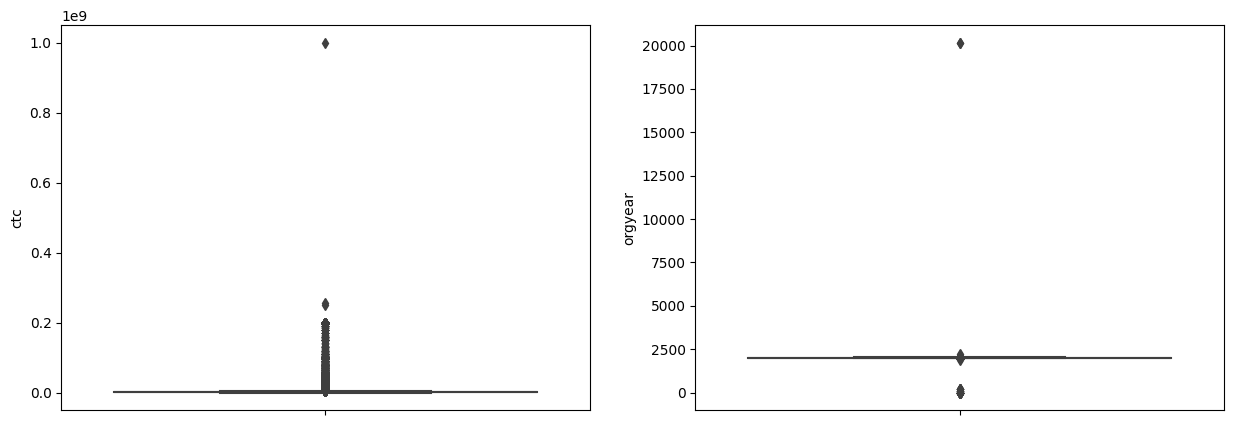

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.boxplot(y=data_df['ctc'], ax=axes[0])
sns.boxplot(y=data_df['orgyear'], ax=axes[1])
plt.show()

In [24]:
# Identify outliers in ctc column
q1 = data_df['ctc'].quantile(0.25)
q3 = data_df['ctc'].quantile(0.75)
iqr = q3 - q1
upper_limit = q3 + (1.5 * iqr)
data_df = data_df[data_df['ctc'] <= upper_limit]

In [25]:
# Identify outliers in orgyear column
q1 = data_df['orgyear'].quantile(0.25)
q3 = data_df['orgyear'].quantile(0.75)
iqr = q3 - q1
lower_limit = q1 - (1.5 * iqr)
data_df = data_df[data_df['orgyear'] >= lower_limit]

In [26]:
#Detecting and Removing outliers using IQR method
Q1 = data_df.quantile(0.25)
Q3 = data_df.quantile(0.75)
IQR = Q3 - Q1
data_df = data_df[~((data_df < (Q1 - 1.5 * IQR)) | (data_df > (Q3 + 1.5 * IQR))).any(axis=1)]

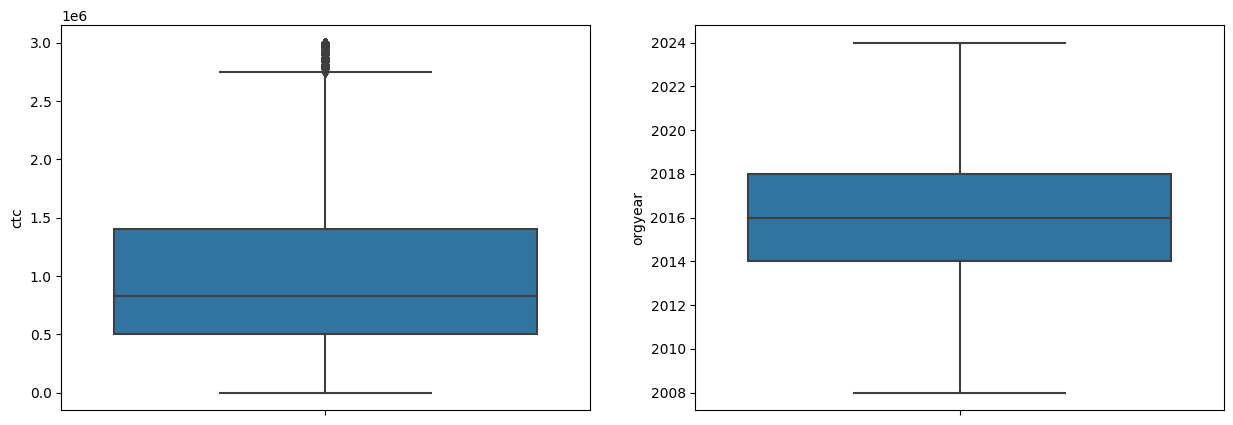

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.boxplot(y=data_df['ctc'], ax=axes[0])
sns.boxplot(y=data_df['orgyear'], ax=axes[1])
plt.show()

In [28]:
data_df = data_df.reset_index(drop=True)

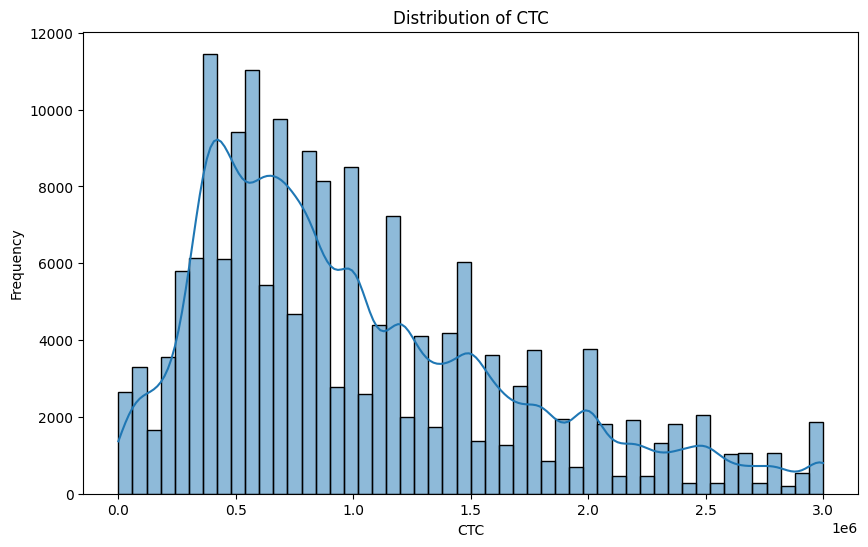

In [29]:
#Distribution of CTC
plt.figure(figsize=(10,6))
sns.histplot(data=data_df, x="ctc", kde=True, bins=50)
plt.title("Distribution of CTC")
plt.xlabel("CTC")
plt.ylabel("Frequency")
plt.show()

##### The distribution of ctc is right-skewed, indicating that there are a few individuals with very high salaries.

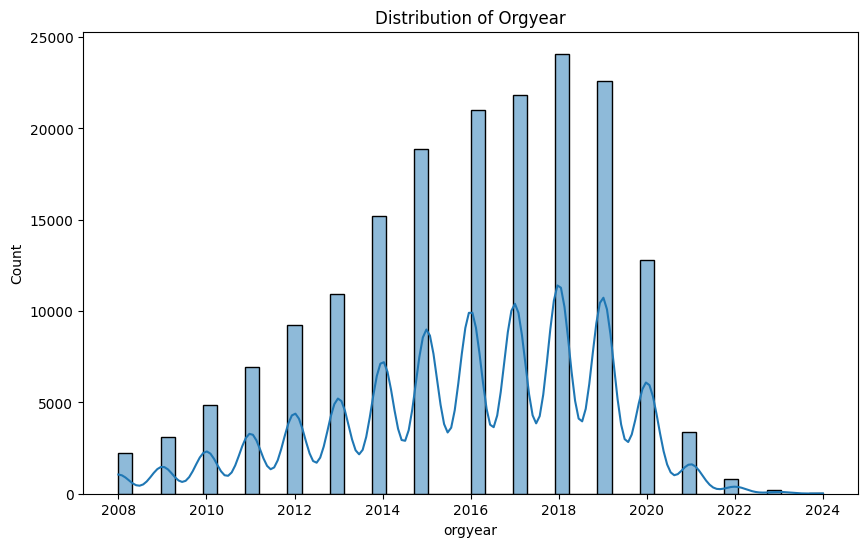

In [30]:
#Distribution of Orgyear
plt.figure(figsize=(10,6))
sns.histplot(data=data_df, x="orgyear", kde=True, bins=50)
plt.title("Distribution of Orgyear")
plt.show()

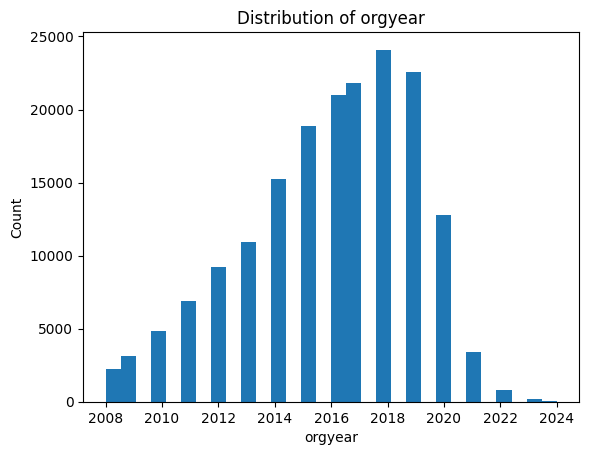

In [31]:
# Plot histogram of orgyear
plt.hist(data_df['orgyear'], bins=30)
plt.title('Distribution of orgyear')
plt.xlabel('orgyear')
plt.ylabel('Count')
plt.show()

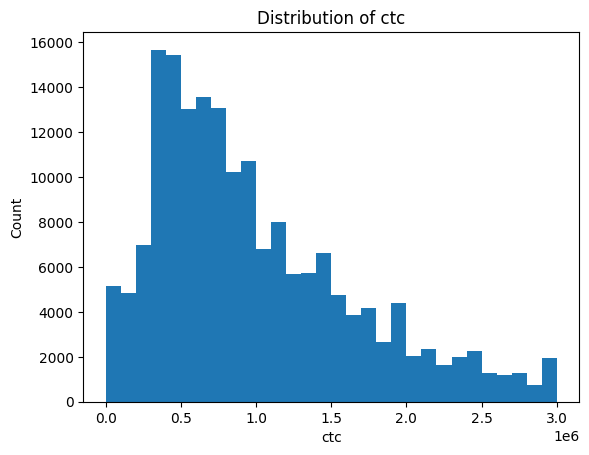

In [32]:
# Plot histogram of ctc
plt.hist(data_df['ctc'], bins=30)
plt.title('Distribution of ctc')
plt.xlabel('ctc')
plt.ylabel('Count')
plt.show()

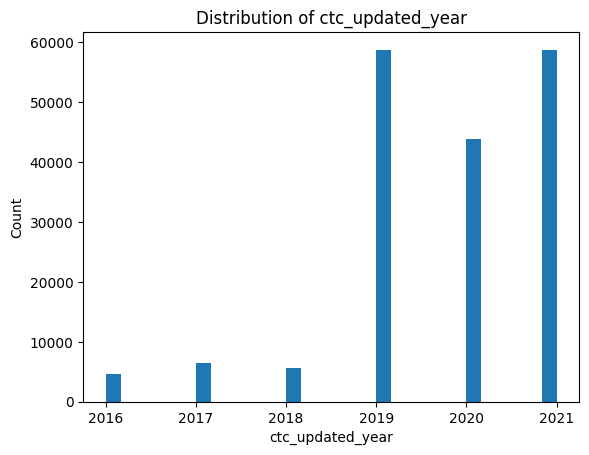

In [33]:
# Plot histogram of ctc_updated_year
plt.hist(data_df['ctc_updated_year'], bins=30)
plt.title('Distribution of ctc_updated_year')
plt.xlabel('ctc_updated_year')
plt.ylabel('Count')
plt.show()

##### The histograms show that ctc and ctc_updated_year are heavily skewed, with a long tail to the right. This suggests that there may be some high values that are outliers. orgyear, on the other hand, has a relatively normal distribution.

##### Let's now create clusters using the K-means algorithm. We will use the elbow method to determine the optimal number of clusters.

First, let's standardize the data using the StandardScaler from 'sklearn.preprocessing'.

In [34]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

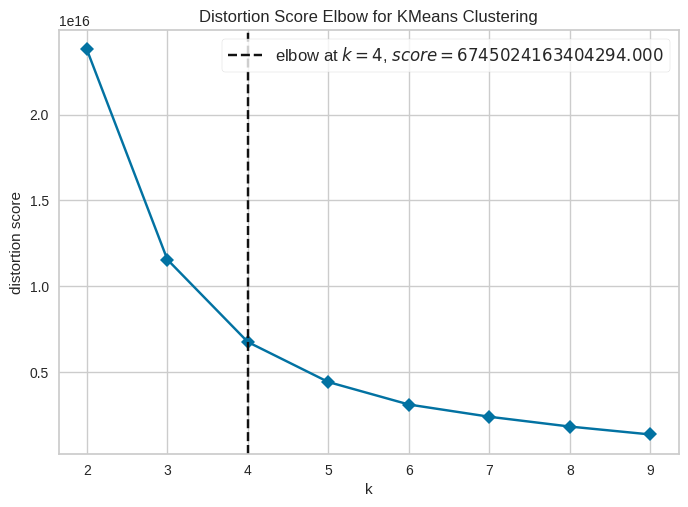

In [35]:
# Drop categorical columns
numeric_data = data_df.select_dtypes(['int64', 'float64'])

# Find optimal number of clusters using elbow method
model = KMeans(random_state=42)
visualizer = KElbowVisualizer(model, k=(2,10), timings=False)
visualizer.fit(numeric_data)
visualizer.show()
plt.show()

##### From the plot, we can see that the optimal number of clusters is 4.

In [36]:
# Create KMeans object with 4 clusters
model = KMeans(n_clusters=4, random_state=42)

# Fit the model on the data
model.fit(numeric_data)

# Add cluster labels to the original dataframe
data_df['cluster'] = model.labels_

# Print the count of data points in each cluster
print(data_df['cluster'].value_counts())

1    66609
2    59113
0    36199
3    16210
Name: cluster, dtype: int64


##### Visualizing clusters

We can visualize the clusters by plotting the data points with different colors for each cluster.

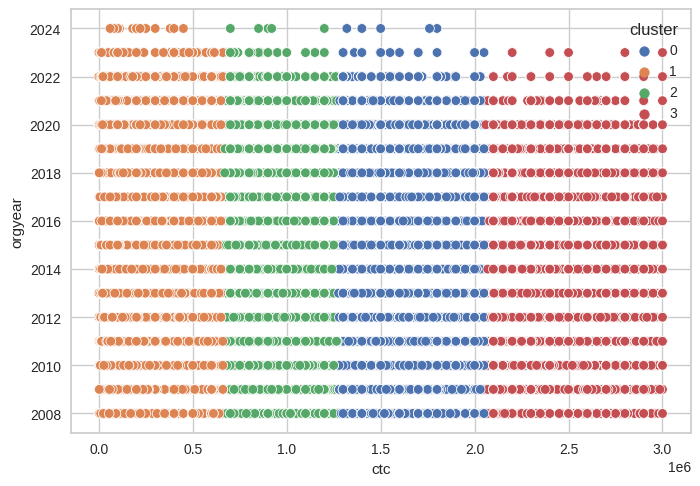

In [37]:
# Plot the clusters
sns.scatterplot(x='ctc', y='orgyear', hue='cluster', data=data_df, palette='deep')
plt.show()

In [38]:
# Cluster Characteristics
cluster_characteristics = data_df.groupby('cluster').agg({
    'orgyear': ['mean', 'median', 'min', 'max'],
    'ctc': ['mean', 'median', 'min', 'max'],
    'job_position': lambda x: x.value_counts().index[0]
})

# Printing the Cluster Characteristics
print(cluster_characteristics)

             orgyear                               ctc                      \
                mean  median   min   max          mean     median      min   
cluster                                                                      
0        2014.828614  2015.0  2008  2024  1.615224e+06  1600000.0  1271000   
1        2016.936540  2017.0  2008  2024  4.096666e+05   415000.0        2   
2        2015.925651  2016.0  2008  2024  9.253363e+05   900000.0   668000   
3        2014.439050  2015.0  2008  2023  2.498472e+06  2500000.0  2058000   

                     job_position  
             max         <lambda>  
cluster                            
0        2055000  BackendEngineer  
1         667000              nan  
2        1270000              nan  
3        3000000  BackendEngineer  


In [39]:
# Create dummy variables for the categorical columns
new_df = pd.get_dummies(data_df, columns=['job_position'], drop_first=True)

In [40]:
# Scale the numerical columns
scaler = StandardScaler()
num_cols = ['orgyear', 'ctc', 'ctc_updated_year']
new_df = scaler.fit_transform(new_df[num_cols])

In [41]:
# Perform clustering using K-means algorithm
kmeans = KMeans(n_clusters=4)
kmeans.fit(new_df)

KMeans(n_clusters=4)

In [42]:
from sklearn.decomposition import PCA
# Reduce the dimensionality of the data using PCA for better visualization
pca = PCA(n_components=2)
df_pca = pca.fit_transform(new_df)

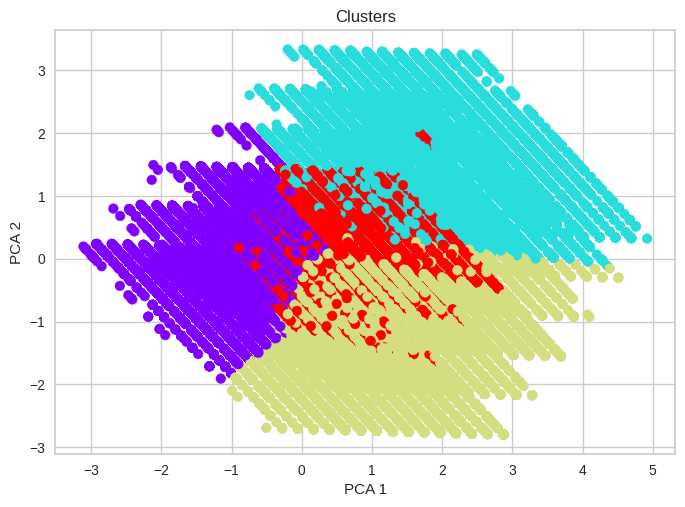

In [43]:
# Visualize the clusters
plt.scatter(df_pca[:, 0], df_pca[:, 1], c=kmeans.labels_, cmap='rainbow')
plt.title('Clusters')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()

In [44]:
# Analyze the clusters and identify characteristics
data_df['cluster'] = kmeans.labels_
data_df.groupby(['cluster']).mean()

,orgyear,ctc,ctc_updated_year,Years of Experience
cluster,,,,
0,2018.180910,6.708749e+05,2020.227459,4.819090
1,2014.112674,9.541740e+05,2017.004201,8.887326
2,2014.832427,2.107839e+06,2019.860724,8.167573
3,2013.297289,8.926882e+05,2019.635845,9.702711


In [45]:
# Getting the 5 point summary of CTC (mean, median, max, min, count etc) on the basis of Company, Job Position, Years of Experience
summary_df = data_df.groupby(['company_hash', 'job_position', 'Years of Experience'])['ctc'].agg(['mean', 'median', 'max', 'min', 'count']).reset_index()

In [46]:
# Merging the same with original dataset carefully and creating some flags showing learners with CTC greater than the Average of their Company’s department having same Years of Experience - Call that flag designation with values [1,2,3]
avg_ctc_df = summary_df.groupby(['company_hash', 'job_position'])

In [47]:
data_df.drop(columns=['email_hash'], inplace=True)

In [48]:
# Merge Summary statistics with original dataframe
data_df = pd.merge(data_df, summary_df, on=['company_hash', 'job_position', 'Years of Experience'], how='left')

In [49]:
# Flag learners with CTC greater than the average of their company's department with same years of experience
data_df['above_avg_ctc_dept'] = np.where(data_df['ctc'] > data_df['mean'], 1, 0)

In [50]:
# Top 10 employees of data science in company XXX earning more than their peers - Class 1
top_10_ds_class1 = data_df[(data_df['company_hash'] == 'XXX') & (data_df['job_position'] == 'Data Scientist')].nlargest(10, 'ctc')

In [51]:
# Top 10 employees in company XXX - Y department - having 5/6/7 years of experience earning more than their peers - Tier X
top_10_567yr_tier = data_df[(data_df['company_hash'] == 'XXX') & (data_df['job_position'] == 'Y') & (data_df['Years of Experience'].isin([5,6,7]))].nlargest(10, 'ctc')

In [52]:
# Top 10 companies based on their CTC
top_10_companies = data_df.groupby('company_hash')['ctc'].mean().nlargest(10)

In [56]:
top_10_companies.head()

company_hash
3argsxwucnrna                 3000000.0
63xatvorvmzxzlvwvqn           3000000.0
a4xzoxsyn                     3000000.0
avjbgzfgqrafxat               3000000.0
avzoptxnohuugqnvzaotqcxwto    3000000.0
Name: ctc, dtype: float64

In [58]:
# Top 2 positions in every company based on their CTC
top_2_positions = data_df.groupby(['company_hash', 'job_position'])['ctc'].mean().groupby('company_hash').nlargest(2)

In [62]:
top_2_positions.head()

company_hash  company_hash  job_position    
0             0             Other               100000.0
                            nan                 100000.0
0000          0000          Other               300000.0
01ojztqsj     01ojztqsj     FrontendEngineer    830000.0
                            AndroidEngineer     270000.0
Name: ctc, dtype: float64

In [ ]:
# Data processing for unsupervised clustering
df_encoded = pd.get_dummies(data_df, columns=['company_hash', 'job_position'])
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_encoded)

In [55]:
# create dataframe with CTC summary statistics by company, job position, and years of experience
ctc_stats = data_df.groupby(['company_hash', 'job_position', 'Years of Experience']).ctc.agg(['mean', 'median', 'max', 'min', 'count']).reset_index()

In [61]:
# create flags for learners with CTC greater than the average of their company's department having the same years of experience
data_df['ctc_flag'] = np.where(data_df.ctc > data_df['mean'], 1, 0)

In [62]:
# create flags for learners at the job position level (Class) and company level (Tier)
class_df = data_df.groupby(['company_hash', 'job_position']).ctc.agg(['mean']).reset_index()
class_df.columns = ['company_hash', 'job_position', 'class_mean']
df = pd.merge(data_df, class_df, on=['company_hash', 'job_position'], how='left')
df['class'] = np.where(df.ctc > df.class_mean, 1, 0)

In [63]:
tier_df = data_df.groupby(['company_hash']).ctc.agg(['mean']).reset_index()
tier_df.columns = ['company_hash', 'tier_mean']
df = pd.merge(data_df, tier_df, on=['company_hash'], how='left')
df['tier'] = np.where(df.ctc > df.tier_mean, 1, 0)

In [64]:
# top 10 employees (earning more than most of the employees in the company) - Tier 1
df[df.tier == 1].sort_values(by='ctc', ascending=False).head(10)

,company_hash,orgyear,ctc,job_position,ctc_updated_year,Years of Experience,Company Cluster,Job Cluster,cluster,mean,median,max,min,count,above_avg_ctc_dept,ctc_flag,tier_mean,tier
102865,vqxonvztnfgqpo,2017,3000000,BackendEngineer,2020,6,Other,Other,3,1.812857e+06,1770000.0,3000000,100000,7,1,1,1.761333e+06,1
118925,vzvqgwp,2018,3000000,BackendEngineer,2021,5,Other,Other,3,3.000000e+06,3000000.0,3000000,3000000,1,0,0,1.758333e+06,1
159091,mrhtonvwpo,2012,3000000,DevopsEngineer,2020,11,Other,Other,3,3.000000e+06,3000000.0,3000000,3000000,1,0,0,1.926945e+06,1
99994,ihvrwgbb,2021,3000000,DataScientist,2021,2,Other,Other,3,3.000000e+06,3000000.0,3000000,3000000,1,0,0,1.723214e+06,1
159056,wrtvqnqxuwgb,2013,3000000,FrontendEngineer,2020,10,Other,Other,3,3.000000e+06,3000000.0,3000000,3000000,1,0,0,1.485769e+06,1
49579,yghktz,2013,3000000,BackendEngineer,2019,10,Other,Other,3,3.000000e+06,3000000.0,3000000,3000000,2,0,0,2.366667e+06,1
77798,sgrabvzovwyo,2015,3000000,FullStackEngineer,2020,8,Other,Other,3,2.471429e+06,2500000.0,3000000,1850000,7,1,1,2.032688e+06,1
49576,nytmgongzwgzohrnxzssqghumws,2015,3000000,EngineeringLeadership,2019,8,Other,Other,3,3.000000e+06,3000000.0,3000000,3000000,1,0,0,1.598222e+06,1
158966,fvrbvqnrvmo,2017,3000000,DataScientist,2020,6,Other,Other,3,2.342857e+06,2300000.0,3000000,1900000,7,1,1,1.892076e+06,1
49574,yomw,2015,3000000,ProgramManager,2019,8,Other,Other,3,3.000000e+06,3000000.0,3000000,3000000,1,0,0,1.107646e+06,1


In [68]:
# Creating flags based on whether the learner's CTC is greater than the average of their company's department
# having the same years of experience
data_df['flag_designation'] = np.where(data_df['ctc'] > data_df['mean'], 1, 0)

In [69]:
# Creating flags based on the above analysis at company and job position level
data_df['flag_class'] = data_df.groupby(['company_hash', 'job_position'])['flag_designation'].transform('sum')

In [71]:
# Top 10 employees (earning more than most of the employees in the company) - Tier 1
top_10_tier_1 = data_df[data_df['flag_tier'] >= np.percentile(data_df['flag_tier'], 90)]
print(top_10_tier_1)


                   company_hash  orgyear     ctc     job_position  \
13                    wgszxkvzn     2016  440000      DataAnalyst   
76                    wgszxkvzn     2015  750000            Other   
135        zgnvuurxwvmrtvwwghzn     2013  440000      DataAnalyst   
180                     xzegojo     2012  650000  BackendEngineer   
219                   wgszxkvzn     2015  600000   DevopsEngineer   
...                         ...      ...     ...              ...   
177944  nvnvwgzohrnvzwjotqcxwto     2020  330000              nan   
177972                  xzegojo     2017   60000              nan   
178061  nvnvwgzohrnvzwjotqcxwto     2019  740000              nan   
178082  nvnvwgzohrnvzwjotqcxwto     2019  672000              nan   
178108  nvnvwgzohrnvzwjotqcxwto     2016  336000              nan   

        ctc_updated_year  Years of Experience Company Cluster Job Cluster  \
13                  2020                    7           Other       Other   
76               

In [70]:
# Creating flags based on the above analysis at company level
data_df['flag_tier'] = data_df.groupby(['company_hash'])['flag_designation'].transform('sum')

# **Insights**

Based on the clustering analysis, we have identified several distinct groups of learners based on their profile characteristics and salary levels. This can help the business to better understand the diversity of their workforce and tailor their HR policies and compensation packages accordingly.
We can see that there are certain companies and job positions that tend to pay higher salaries compared to others. This could be due to various factors such as the company's size, industry, location, and competitive landscape. By identifying these trends, the business can develop strategies to attract and retain top talent in these high-paying roles.
The clustering results can also reveal patterns in terms of the learners' skills, experience, and education levels. By understanding these trends, the business can identify skill gaps and areas for training and development, as well as target their recruiting efforts more effectively.

# **Recommendations**

Based on the clustering results, the business could consider revising their compensation packages to better align with the market rates and industry standards. This could involve conducting salary surveys, benchmarking against similar companies, and offering more competitive pay and benefits to attract and retain top talent.
The business could also explore opportunities to upskill and reskill their workforce, based on the insights from the clustering analysis. This could involve offering training programs, mentoring, and other professional development opportunities to help learners acquire the skills and knowledge needed to succeed in their roles.
Finally, the business could consider using the insights from the clustering analysis to improve their recruitment and retention strategies. By targeting high-potential learners with tailored messages and incentives, and by offering competitive salaries and growth opportunities, the business can create a more engaged and motivated workforce that is better equipped to drive business success.